<center><h1> KPMG Machine Learning Modelling Part <center><h1>

## Load Libraries for Cleaning and Modelling

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn


# Imputing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modelling Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing


# Supervised
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import RBFSampler

from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# XGBoost library to use.
import xgboost as xgb

# An sklearn wrapper for XGBoost. Imported to use sklearn's Grid Search with parallel processing.
from xgboost import XGBClassifier

import shap
shap.initjs()

# Metrics 
from sklearn.metrics import *

## Explore the Data Frame

In [2]:
df = pd.read_excel('Features_tagging_v3-2nd_line_class1.xlsx', sheet_name = 'features_v7', header = 1)

# df = pd.read_excel('./tagged_round_one.xlsx', sheet_name = 'features_v7', header = 1)

In [3]:
df.shape

(41910, 34)

In [4]:
df.sample(3)

,text,document,Name,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,class,...,Num_Words,String_Length,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS
15520,this exemption.,html_files/CMS_2014_0115_53135.pdf,NaN,NaN,NaN,NaN,NaN,NaN,29801,txt,...,2,15,0,0,1,0,0,0,54,16.0
5275,to either self-certify to the insurer or TPA o...,html_files/CMS_2014_0115_13166.pdf,Liliana,NaN,NaN,NaN,NaN,0.0,34331,txt,...,18,103,0,0,0,0,0,0,72,10.0
2578,"induced abortion, can apply for and be granted...",html_files/CMS_2014_0115_12762.pdf,pranjal,NaN,NaN,NaN,NaN,0.0,13163,txt,...,13,99,0,0,0,0,0,0,71,12.0


#### Missing data analysis

* `line_height` is completely missing 
* `LS` has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0. 
* The rest of the missing columns are those that we made ourselves to tag the feature. We will be dropping them. 

In [5]:
df.isna().sum() 

text                         0
document                     0
Name                     28755
Section_Id_Document      41013
Section_ID               41011
Paragraph                40676
Comment                  39717
Class                    31356
df_idx                       0
class                        0
style                        0
id                           0
font-size                    0
vertical-align               0
color                        0
font-family                  0
font-weight                  0
font-style                   0
position                     0
left                         0
top                          0
document_id                  0
page                         0
line-height              41906
Num_Words                    0
String_Length                0
Leading_Char_Upper           0
Leading_Numeral              0
Ends_In_Period               0
Leading_Number_Period        0
Leading_Char_Period          0
Roman_Period                 0
Left_Px 

#### Get document count

In [6]:
num_docs = len(df.groupby('document').count()['text'].rename('Count'))
num_docs

119

#### Drop rows which are not labelled

In [7]:
df = df[df['Class'].isna()==False]

#### See how many documents are done and percentage

In [8]:
num_docs_done = len(df.groupby('document').count()['text'].rename('Count'))

In [9]:
num_docs_done / num_docs

0.3445378151260504

#### Number of Tags Completed: By team member

In [10]:
df.groupby('Name').count()['text'].rename('Count').sort_values()

Name
pranjal    1287
Liliana    2119
gayani     2478
Minsu      4670
Name: Count, dtype: int64

## Extract Text Features: Gayani's Part

### Check the data types in text column

In [11]:
# df['stringy'] = [isinstance(x, str) for x in df.text]

In [12]:
df['font-weight'] = df['font-weight'].map({'bold': 1, 'normal': 0})
df['font-style'] = df['font-style'].map({'italic': 1, 'normal': 0})

### Extract first 3 words, 5 words, first word,last word, contain(introduction),contain(conclusion)

In [13]:
df.sample(5)

,text,document,Name,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,class,...,Num_Words,String_Length,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS
35795,being.,html_files/CMS_2014_0115_58260.pdf,Minsu,NaN,NaN,NaN,NaN,0.0,29365,txt,...,1,6,0,0,1,0,0,0,72,16.0
5134,decision to invoke the accommodation. Without ...,html_files/CMS_2014_0115_13164.pdf,Liliana,NaN,NaN,NaN,NaN,0.0,35178,txt,...,15,95,0,0,0,0,0,0,90,12.0
3501,establishes a strong precedent. Rather than cr...,html_files/CMS_2014_0115_12938.pdf,pranjal,NaN,NaN,NaN,NaN,0.0,35805,txt,...,16,105,0,0,0,0,0,0,71,16.0
41324,"comment on the proposed rules, “Coverage of Ce...",html_files/CMS_2014_0115_6108.pdf,Minsu,NaN,NaN,NaN,NaN,0.0,38734,txt,...,13,92,0,0,0,0,0,0,72,13.0
36279,created an out-of-pocket savings of approximat...,html_files/CMS_2014_0115_58260.pdf,Minsu,NaN,NaN,NaN,NaN,0.0,28991,txt,...,11,80,0,0,0,0,0,0,72,18.0


In [14]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

In [15]:
### Convert the text column data type to string

df['text'] = df['text'].apply(str)

### Three gram

df['3_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 3))
#df['new_col'] = df.triigrams.apply(lambda x: x[0:1])
df['first_3_words'] = df["3_grams"].str[0]
df['first_3_words'] = df['first_3_words'].apply(str)
df['first_3_words'] = df['first_3_words'].str.replace(r'[^\w\s]+', '')

### Five gram

df['5_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 5))
#df['new_col'] = df.triigrams.apply(lambda x: x[0:1])
df['first_5_words'] = df['5_grams'].str[0]
df['first_5_words'] = df['first_5_words'].apply(str)
df['first_5_words'] = df['first_5_words'].str.replace(r'[^\w\s]+', '')


### I will drop 3-gram and 5_gram columns and keep only fist three words and first five words columns

df = df.drop(['3_grams', '5_grams'], axis = 1)


In [16]:
### Extract first and last word

df["First_Word"] = df["text"].apply(lambda x: x.split()[0:1])
df["First_Word"] = df["First_Word"].apply(str)
df["First_Word"] = df["First_Word"].str.replace(r'[^\w\s]+', '')

df["Last_Word"] = df["text"].apply(lambda x: x.split()[-1:])
df["Last_Word"] = df["Last_Word"].apply(str)
df["Last_Word"] = df["Last_Word"].str.replace(r'[^\w\s]+', '')

### 

df['Start_Introduction'] = df['First_Word'].str.contains('Introduction')
df['Start_Introduction'] = df['Start_Introduction'].map({True: '1', False: '0'})

df['Start_conclusion'] = df['First_Word'].str.contains('conclusion')
df['Start_conclusion'] = df['Start_conclusion'].map({True: '1', False: '0'})



In [17]:
# SAVE: Please don't ever save documents in the directory which you will push 
# since we don't want to commit our data to github
df.to_csv('../../../featuresV9.csv')

## Data Cleaning

1. Drop irrelavant columns
2. Convert columns kept to right types 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10554 entries, 0 to 41909
Data columns (total 40 columns):
text                     10554 non-null object
document                 10554 non-null object
Name                     10554 non-null object
Section_Id_Document      897 non-null float64
Section_ID               899 non-null float64
Paragraph                1234 non-null object
Comment                  2193 non-null object
Class                    10554 non-null float64
df_idx                   10554 non-null int64
class                    10554 non-null object
style                    10554 non-null object
id                       10554 non-null object
font-size                10554 non-null object
vertical-align           10554 non-null object
color                    10554 non-null object
font-family              10554 non-null object
font-weight              10554 non-null int64
font-style               10554 non-null int64
position                 10554 non-null object
left

### 1. Drop Irrelavant Columns 
* Drop text since we don't really need it and are using derived features from it 
* Drop columns that we created ourselves for tagging:
`Name`, `section Id document`, `document id`, `section id`, `Comment`, `Paragraph` are not useful since we created them for labelling or target
* `df_idx` is the same thing as document_id and document 
* We keep `document` : we will cat encdode it later 
* Remove `class` (lowercase) since it only has one value
* Drop `position` since it only has one value
* `line height` has nothing in it ... only **nans** 
* Remove `string length` since it's correlated with numwords
* Remove `Left_Px` since it's the same thing as `left` which I clean in the next section

In [19]:
df = df.drop(['text', 'Name', 'Section_Id_Document', 'document_id',
             'Section_ID', 'Comment', 'Paragraph', 'df_idx' , 'class', 'position',
              'page', 'line-height', 'String_Length', 'Left_Px'], axis = 1)

Columns that I may remove later:
- `id`: Not sure what that means
- `page`: Not sure if it's relevant at all
- `color`: Need to clean it but may not give any feature importance

### 2. Clean columns:  `fontsize`, `left` and `top`: 
- Remove px and 
- Convert to right data typ

In [20]:
df['font-size'] = df['font-size'].str.replace('px', '')
df['font-size'] = pd.to_numeric(df['font-size'])

df['left'] = df['left'].str.replace('px', '')
df['left'] = pd.to_numeric(df['left'])

df['top'] = df['top'].str.replace('px', '')
df['top'] = pd.to_numeric(df['top'])

## Modelling
#### Part I: Data Cleaning and Preparation
1. Separate Target and Data
2. Split into Test and Train
3. Clean Numeric Features 
4. Clean Categorical Features
4. Try NLP Techniques
6. Combine Data Frames

#### Part II: Models
1. Logistic Regression
2. Naive Bayers Classification 
3. Random Forest
4. **Playing with Evaluation Metrics**
5. Boosting: AdaBoost and Gradient Boosting
6. Boosting: XGBoost

### Part 1: Prepare

#### 1. Separate Target and Features 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10554 entries, 0 to 41909
Data columns (total 26 columns):
document                 10554 non-null object
Class                    10554 non-null float64
style                    10554 non-null object
id                       10554 non-null object
font-size                10554 non-null int64
vertical-align           10554 non-null object
color                    10554 non-null object
font-family              10554 non-null object
font-weight              10554 non-null int64
font-style               10554 non-null int64
left                     10554 non-null int64
top                      10554 non-null int64
Num_Words                10554 non-null int64
Leading_Char_Upper       10554 non-null int64
Leading_Numeral          10554 non-null int64
Ends_In_Period           10554 non-null int64
Leading_Number_Period    10554 non-null int64
Leading_Char_Period      10554 non-null int64
Roman_Period             10554 non-null int64
LS       

In [22]:
df.shape

(10554, 26)

In [23]:
X = df.drop(['Class'], axis = 1)

y = df['Class']

In [24]:
X.shape

(10554, 25)

#### Check out imbalance

In [25]:
imbalance = (len(y[y == 1]) / len(y)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 2.14%


#### 2. Train Test Split

In [26]:
# 30% will be selected for testing data randomly
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

#### 3. Clean up Numeric features 

In [27]:
X_train_num = X_train.select_dtypes(exclude="object")

In [28]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7387 entries, 3324 to 5064
Data columns (total 13 columns):
font-size                7387 non-null int64
font-weight              7387 non-null int64
font-style               7387 non-null int64
left                     7387 non-null int64
top                      7387 non-null int64
Num_Words                7387 non-null int64
Leading_Char_Upper       7387 non-null int64
Leading_Numeral          7387 non-null int64
Ends_In_Period           7387 non-null int64
Leading_Number_Period    7387 non-null int64
Leading_Char_Period      7387 non-null int64
Roman_Period             7387 non-null int64
LS                       7188 non-null float64
dtypes: float64(1), int64(12)
memory usage: 808.0 KB


In [29]:
X_train_num.sample(3)

,font-size,font-weight,font-style,left,top,Num_Words,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,LS
5041,12,0,1,45,418,17,1,0,0,0,0,0,16.0
35593,10,0,0,86,529,11,1,0,0,0,0,0,13.0
1218,12,0,0,72,493,12,0,0,0,0,0,0,14.0


#### Split into binary and continuous

In [30]:
X_train_cont = X_train_num[['font-size', 'left', 'top', 'Num_Words', 'LS']]

In [31]:
X_train_binary = X_train_num[['font-weight', 'font-style', 'Leading_Char_Upper',
                'Leading_Numeral', 'Ends_In_Period', 'Leading_Number_Period',
                'Leading_Char_Period', 'Roman_Period']]

In [32]:
print(X_train_cont.shape)
print(X_train_binary.shape)
print(X_train_num.shape)

(7387, 5)
(7387, 8)
(7387, 13)


#### Impute Missing Column: LS
LS has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0.

In [33]:
####### Commneted out for XGBoost ######################
# X_train_cont['LS'] = X_train_cont['LS'].fillna(0)
####### Commneted out for XGBoost ######################
# We remain missing values of LS.
# Why? When xgboost encounters a missing value at a node,
# it tries both left and right hand split and learns the way leading to higher loss for each node.
# It then does the same when working on testing data.
# Source: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
X_train_cont['LS_missing'] = X_train_cont['LS'].isna()

/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [34]:
X_train_cont.isna().sum() 

font-size       0
left            0
top             0
Num_Words       0
LS            199
LS_missing      0
dtype: int64

#### Combine DFs to get X_Numeric

In [35]:
X_train_num = pd.concat([X_train_cont, X_train_binary], axis = 1)

#### 4. Clean up Non-Numeric features

In [36]:
X_train_cat = X_train.select_dtypes(include="object")

In [37]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7387 entries, 3324 to 5064
Data columns (total 12 columns):
document              7387 non-null object
style                 7387 non-null object
id                    7387 non-null object
vertical-align        7387 non-null object
color                 7387 non-null object
font-family           7387 non-null object
first_3_words         7387 non-null object
first_5_words         7387 non-null object
First_Word            7387 non-null object
Last_Word             7387 non-null object
Start_Introduction    7387 non-null object
Start_conclusion      7387 non-null object
dtypes: object(12)
memory usage: 750.2+ KB


In [38]:
X_train_cat.sample(3)

,document,style,id,vertical-align,color,font-family,first_3_words,first_5_words,First_Word,Last_Word,Start_Introduction,Start_conclusion
41267,html_files/CMS_2014_0115_58449.pdf,font-size:10px;vertical-align:baseline;color:r...,f4,baseline,"rgba(0,0,0,1)",sans-serif,situationsu200b wu200b hereu200b,situationsu200b wu200b hereu200b Cu200b ongres...,situationsu200b,xists,0,0
40406,html_files/CMS_2014_0115_58438.pdf,font-size:10px;vertical-align:baseline;color:r...,f3,baseline,"rgba(0,0,0,1)",sans-serif,The ERLC respectfully,The ERLC respectfully urges ﬁnalization,The,as,0,0
40785,html_files/CMS_2014_0115_58448.pdf,font-size:10px;vertical-align:baseline;color:r...,f2,baseline,"rgba(0,0,0,1)",serif,16081615 2016 Michelle,16081615 2016 Michelle Andrews IUD,16081615,Contraceptives,0,0


In [39]:
####### Commneted out for XGBoost ######################
# X_train_text = X_train_cat[['first_3_words', 'first_5_words', 
#                 'First_Word', 'Last_Word', 'Start_Introduction', 
#                 'Start_conclusion']]
####### Commneted out for XGBoost ######################
X_train_text = X_train_cat[['first_3_words']]

In [40]:
####### Commneted out for XGBoost ######################
# X_train_non_text = X_train_cat[['document', 'style', 'id', 
#                                 'color', 'font-family', 'vertical-align']]
####### Commneted out for XGBoost ######################
X_train_non_text = X_train_cat[['document']]

In [41]:
print(X_train_text.shape)
print(X_train_non_text.shape)
print(X_train_cat.shape)

(7387, 1)
(7387, 1)
(7387, 12)


In [42]:
X_train.drop(['first_5_words', 'First_Word', 'Last_Word', 'Start_Introduction', 'Start_conclusion'], axis=1, inplace=True)
X_test.drop(['first_5_words', 'First_Word', 'Last_Word', 'Start_Introduction', 'Start_conclusion'], axis=1, inplace=True)
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)

# Drop columns that make less sense as a feature.
X_train.drop(['index', 'top'], axis=1, inplace=True)
X_test.drop(['index', 'top'], axis=1, inplace=True)

/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
####### Run all above only and go directly to 6.XGBoost to run an XGBoost model ######################

#### OneHotEncode `First Word` Column

In [ ]:
one_hot_first_word = pd.get_dummies(X_train_text['First_Word'])

In [ ]:
one_hot_first_word.shape

#### OneHotEncode Non-Text Columns

In [ ]:
sum = 0
for col in X_train_non_text:
    print(len(X_train_non_text[col].unique()))
    sum += len(X_train_non_text[col].unique())
print("Sum =",sum) 

In [ ]:
X_train_non_text = pd.get_dummies(X_train_non_text)

In [ ]:
X_train_non_text.shape

### NLP Techniques: Get Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
first_3_words = X_train_text['first_3_words']

In [ ]:
vect_first_3 = CountVectorizer().fit(first_3_words)
bag_of_words_first_3 = vect_first_3.transform(first_3_words)

In [ ]:
sdf_3 = pd.SparseDataFrame(bag_of_words_first_3,
                         columns=vect_first_3.get_feature_names(), 
                         default_fill_value=0)

In [ ]:
first_5_words = X_train_text['first_5_words']

In [ ]:
vect_first_5 = CountVectorizer().fit(first_5_words)
bag_of_words_first_5 = vect_first_5.transform(first_5_words)

In [ ]:
sdf_5 = pd.SparseDataFrame(bag_of_words_first_5,
                         columns=vect_first_5.get_feature_names(), 
                         default_fill_value=0)

#### Stop Words + Ngrams

In [ ]:
CountVectorizer(stop_words='english', ngram_range=(1, 2))

In [ ]:
TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

#### 5. Combine Data Frames

#### Categorical Data: 
**Note: I don't think we need the column start introduction or start conclusion since we already have a First Word Column**
1. Keep all non-text columns: OneHotEncoded
2. Create 3 versions:
    * First word
    * First 3 words
    * First 5 words 
 


In [ ]:
# reset index for all
X_train_non_text.reset_index(inplace = True)
one_hot_first_word.reset_index(inplace = True)
sdf_3.reset_index(inplace = True)
sdf_5.reset_index(inplace = True)

In [ ]:
X_train_cat_1 = pd.concat([X_train_non_text, one_hot_first_word], axis = 1)

In [ ]:
X_train_cat_1.head()

In [ ]:
print(X_train_non_text.shape)
print(one_hot_first_word.shape)
print(X_train_cat_1.shape)

In [ ]:
# drop index
X_train_cat_1.drop(['index'], axis = 1, inplace = True)

In [ ]:
print(X_train_cat_1.shape)

In [ ]:
X_train_cat_2 = pd.concat([X_train_non_text, sdf_3], axis = 1)

In [ ]:
print(X_train_non_text.shape)
print(sdf_3.shape)
print(X_train_cat_2.shape)

In [ ]:
# drop index
X_train_cat_2.drop(['index'], axis = 1, inplace = True)

In [ ]:
print(X_train_cat_2.shape)

In [ ]:
X_train_cat_3 = pd.concat([X_train_non_text, sdf_5], axis = 1)

In [ ]:
print(X_train_non_text.shape)
print(sdf_5.shape)
print(X_train_cat_3.shape)

In [ ]:
# drop index
X_train_cat_3.drop(['index'], axis = 1, inplace = True)

In [ ]:
print(X_train_cat_3.shape)

#### Target-based Encoding to reduce dimensions created by OneHotEncoding

In [ ]:
# Try later

#### Combine Numerical and Categorical

In [ ]:
# reset index for all
X_train_num.reset_index(inplace = True)
X_train_cat_1.reset_index(inplace = True)
X_train_cat_2.reset_index(inplace = True)
X_train_cat_3.reset_index(inplace = True)

In [ ]:
X_train = pd.concat([X_train_num, X_train_cat_2], axis = 1)

In [ ]:
print(X_train_num.shape)
print(X_train_cat_1.shape)
print(X_train.shape)

In [ ]:
# drop index
X_train.drop(['index'], axis = 1, inplace = True)

In [ ]:
print(X_train.shape)

### Part 2: Models

### 1. Logistic Regression

#### Look at cross-validated performance

In [ ]:
lr_scores = cross_val_score(LogisticRegression(solver = 'lbfgs'), 
                        X_train, y_train, 
                        cv = 5,
                        scoring= 'roc_auc') # cross validation
lr_mean_score = np.mean(lr_scores)

In [ ]:
lr_mean_score

In [ ]:
plt.plot(lr_scores)
plt.axhline(lr_mean_score, color='r', linestyle='--') # plot mean line 
plt.show()

#### Fit one model

In [ ]:
lr = LogisticRegression(penalty = 'l2', 
                        C = 1, 
                        class_weight = 'balanced', 
                        solver = 'sag', 
                        max_iter = 100, 
                        random_state = 4896) 
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_train)

#### Model Performance

In [ ]:
def metrics(y_test, y_pred):
    print("Score on Train set")
    print("Accuracy score: {:.2f}".format(accuracy_score(y_train, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_train, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_train, y_pred)))

In [ ]:
metrics(y_train, y_pred)

In [ ]:
def confusion_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])

In [ ]:
confusion_metrics(y_train, y_pred)

#### Look at the Important Features

In [ ]:
def plot_top_k_feature_importances(coefs, k):    
    # sort 
    args = coefs.argsort()[::-1][:k]    
    # get coefs 
    top_k_coefs = coefs[args]    
    # get column names
    colnames = list(X_train.columns.values[args])
    # plot 
    plt.barh(range(k), top_k_coefs, align='center') 
    plt.yticks(np.arange(k), colnames) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, k)
    plt.show()

In [ ]:
plot_top_k_feature_importances(lr.coef_[0], 20)

### 2. Naive Bayers Classification

In [ ]:
# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(X_train, y_train)

# Make predictions
preds = gnb.predict(X_train)

NB classifier is 98% accurate. This means that 98 percent of the time the classifier is able to make the correct prediction as to whether or not the it is a section. 

In [ ]:
confusion_metrics(y_train, y_pred)

In [ ]:
confusion_metrics(y_train, y_pred)

### Changing Thresholds for Evaluation

In [ ]:
# y_pred = lr.predict_proba(X_test)[:, 1] > .5
# print(classification_report(y_test, y_pred))

In [ ]:
# confusion_metrics(y_test, y_pred)

### 3. Random Forest

In [ ]:
%%time

#apply grid search on random forest regressor
param_grid = {"n_estimators": [200, 500],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False]}

rf = RandomForestClassifier() 
grid = GridSearchCV(estimator=rf, cv=5, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_ 

In [ ]:
y_pred = grid.predict(X_train)

#### Model Performance

In [ ]:
metrics(y_train, y_pred)

In [ ]:
confusion_metrics(y_train, y_pred)

#### Look at the Important Features

In [ ]:
importances = grid.best_estimator_.feature_importances_

In [ ]:
plot_top_k_feature_importances(importances, 20)

### 4. Playing with Evaluation Metrics

#### 4.1 Changing Thresholds

In [ ]:
y_pred = rf.predict_proba(X_train)[:, 1] > .5
print(classification_report(y_train, y_pred))

#### 4.2 Caliberation Curve for Random Forest: This is still not complete so SKIP this part

In [ ]:
probs = rf.predict_proba(X_train)[:, 1]
prob_true, prob_pred = calibration_curve(y_train, probs, n_bins=5)
print(prob_true)
print(prob_pred)

In [ ]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)

plt.show()

### 5. Boosting: Adaboost

In [ ]:
ab = AdaBoostClassifier() 
ab.fit(X_train, y_train)

In [ ]:
y_pred = ab.predict(X_train)

#### Model Performance

In [ ]:
metrics(y_train, y_pred)

In [ ]:
confusion_metrics(y_train, y_pred)

In [ ]:
plot_top_k_feature_importances(ab.feature_importances_, 20)

### 5. Boosting: Gradient Boosting

### 6. XGBoost

#### Preprocessing for XGBoost
  - dtypes that XGBoost can take are int, float and bool.
  - We encode all categorical variables, accordingly.
  - This encoding doesn't have to be one-hot encoding.

In [87]:
X_train_encoded

,font-size,font-weight,font-style,left,Num_Words,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,LS,document_encoded,style_encoded,id_encoded,vertical-align_encoded,color_encoded,font-family_encoded,first_3_words_encoded
0,11,0,0,126,12,0,0,0,0,0,0,14.0,12,4,44,0,1,1,4265
1,10,0,0,67,20,1,0,0,0,0,0,27.0,35,1,51,0,1,1,2029
2,9,0,0,54,17,0,1,0,0,0,0,15.0,28,49,38,0,1,1,550
3,12,0,0,72,3,1,0,0,0,0,0,NaN,11,8,0,0,1,2,4252
4,11,0,0,108,14,1,0,0,0,0,0,25.0,24,4,0,0,1,2,1999
5,12,0,1,72,15,1,0,0,0,0,0,13.0,6,8,46,0,1,2,1781
6,11,0,0,72,13,1,0,0,0,0,0,14.0,21,4,0,0,1,2,1223
7,11,0,0,72,13,0,0,0,0,0,0,36.0,16,4,0,0,1,1,3150
8,10,0,0,72,6,1,0,0,0,0,0,14.0,10,1,0,0,1,1,1049
9,10,0,0,69,13,0,0,0,0,0,0,12.0,26,0,38,0,0,1,4613


In [44]:
# Additional preprocessing for XGBoost.
lb_train_encoder_list = []
lb_test_encoder_list = []
encodee_cols = X_train.select_dtypes(exclude=['int','float','bool']).columns
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Encode categorical variables and add them into the dataset with a suffiix, '_encoded'
for i, c in enumerate(encodee_cols) :
    lb_train_encoder_list.append(preprocessing.LabelEncoder())
    lb_train_encoder_list[i].fit(X_train[c])
    lb_test_encoder_list.append(preprocessing.LabelEncoder())
    lb_test_encoder_list[i].fit(X_test[c])
    X_train_encoded = pd.concat([X_train_encoded,
                                 pd.Series(lb_train_encoder_list[i].transform(X_train[c]), name=c+'_encoded')],
                                axis=1)
    X_test_encoded = pd.concat([X_test_encoded,
                                 pd.Series(lb_test_encoder_list[i].transform(X_test[c]), name=c+'_encoded')],
                                axis=1)

# Drop the original, non-encoded, categorical variables.
X_train_encoded.drop(list(encodee_cols), axis=1, inplace=True)
X_test_encoded.drop(list(encodee_cols), axis=1, inplace=True)


In [45]:
# to prevent XGBoost from being died
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [46]:
# xgb_train = xgboost.DMatrix(X_train_encoded, label=y_train)
# xgb_test = xgboost.DMatrix(X_test_encoded, label=y_test)

### Running a model with cross-validation applied

In [47]:
# A main reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def xgboost_fit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        # get_xgb_params() is one of sklearn wrappers of xgboost package.
        # It returns parameters in actual xgboost format (not sklearn wrapper's)
        # We use this because the cv function requires parameters in that format.
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                    metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print("The best value of n_estimators is {:d}.".format(cvresult.shape[0]))
        print("Will use and set this value as the parameter, accordingly.")
        alg.set_params(n_estimators=cvresult.shape[0])
        
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], y_train)

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprb = alg.predict_proba(dtrain[predictors])[:, 1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Step 1: Fix a learning rate, and set parameters without tuned. It will be tuned later.
  - I removed the index column, which happens to have the highest feature importance.
  - I am suspicious of *top* being one of the highest feature importance, but chose to leave it there because I don't know for sure what is going on behind the scene yet.
  
#### Tuning information and codes :
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

The best value of n_estimators is 175.
Will use and set this value as the parameter, accordingly.


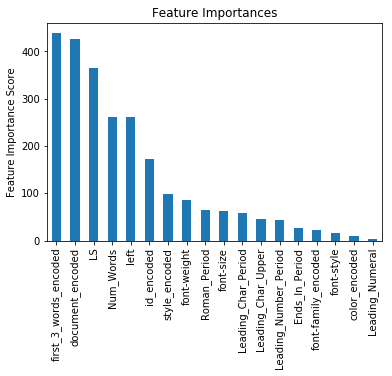

In [48]:
predictors = [x for x in X_train_encoded.columns]

xgb1 = xgb.XGBClassifier(
        # Used to control over-fitting as higher depth will allow model
        # to learn relations very specific to a particular sample.
        # Should be tuned using CV.
        # Typical values: 3-10
        max_depth=5,

        # Analogous to learning rate in GBM
        # Makes the model more robust by shrinking the weights on each step
        # Typical final values to be used: 0.01-0.2
        # default=0.3
        #eta=0.05,

        # Defines the minimum sum of weights of all observations required in a child.
        # This is similar to min_child_leaf in GBM but not exactly.
        # Used to control over-fitting. Higher values prevent a model from
        # learning relations which might be highly specific to the particular
        # sample selected for a tree.
        # Too high values can lead to under-fitting hence,
        # it should be tuned using CV.
        # default=1
        min_child_weight=1,

        learning_rate=0.1,
        n_estimators=1000,

        # one of binary:logistic, multi:softmax, multi:softprob
        objective='binary:logistic',

        # usually misunderstood parameter, it acts as a regularization parameter.
        # either 0, 1 or 5. default=0
        gamma=0,

        # Lower values make the algorithm more conservative
        # and prevents overfitting but too small values might lead to under-fitting.
        # typically 0.5-1
        subsample=1,

        # number of columns used by each tree.
        # In order to avoid some columns to take too much credit
        # for the prediction (think of it like in recommender systems
        # when you recommend the most purchased products and
        # forget about the long tail), take out a good proportion of columns.
        # Values from 0.3 to 0.8 if you have many columns
        # (especially if you did one-hot encoding),
        # or 0.8 to 1 if you only have a few columns.
        colsample_bytree=0.8,

        # Denotes the subsample ratio of columns for each split, in each level.
        # I don’t use this often because subsample and colsample_bytree
        # will do the job for you. but you can explore further if you feel so.
        # default=1
        colsample_bylevel=1,

        # L1 regularization term on weight (analogous to Lasso regression)
        # Can be used in case of very high dimensionality so that
        # the algorithm runs faster when implemented
        # default=0
        reg_alpha=0,

        # L2 regularization term on weights (analogous to Ridge regression)
        # This used to handle the regularization part of XGBoost.
        # Though many data scientists don’t use it often,
        # it should be explored to reduce overfitting.
        # default=1
        reg_lambda=0,

        # A value greater than 0 should be used in case of
        # high class imbalance as it helps in faster convergence.
        # default=1
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb1, X_train_encoded, predictors)

$Tuned$
- *n_estimators* = 175 (The number of trees)

In [49]:
# # Tuning info, among others,
# # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# # https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
# clf = xgboost.XGBClassifier(
#                             # Used to control over-fitting as higher depth will allow model
#                             # to learn relations very specific to a particular sample.
#                             # Should be tuned using CV.
#                             # Typical values: 3-10
#                             max_depth=7,

#                             # Analogous to learning rate in GBM
#                             # Makes the model more robust by shrinking the weights on each step
#                             # Typical final values to be used: 0.01-0.2
#                             # default=0.3
#                             eta=0.05,
    
#                             # Defines the minimum sum of weights of all observations required in a child.
#                             # This is similar to min_child_leaf in GBM but not exactly.
#                             # Used to control over-fitting. Higher values prevent a model from
#                             # learning relations which might be highly specific to the particular
#                             # sample selected for a tree.
#                             # Too high values can lead to under-fitting hence,
#                             # it should be tuned using CV.
#                             # default=1
#                             min_child_weight=1,
    
#                             learning_rate=0.01,
#                             n_estimators=500,
    
#                             # one of binary:logistic, multi:softmax, multi:softprob
#                             objective='binary:logistic',
                            
#                             # usually misunderstood parameter, it acts as a regularization parameter.
#                             # either 0, 1 or 5. default=0
#                             gamma=0,

#                             # Lower values make the algorithm more conservative
#                             # and prevents overfitting but too small values might lead to under-fitting.
#                             # typically 0.5-1
#                             subsample=1,

#                             # number of columns used by each tree.
#                             # In order to avoid some columns to take too much credit
#                             # for the prediction (think of it like in recommender systems
#                             # when you recommend the most purchased products and
#                             # forget about the long tail), take out a good proportion of columns.
#                             # Values from 0.3 to 0.8 if you have many columns
#                             # (especially if you did one-hot encoding),
#                             # or 0.8 to 1 if you only have a few columns.
#                             colsample_bytree=0.8,

#                             # Denotes the subsample ratio of columns for each split, in each level.
#                             # I don’t use this often because subsample and colsample_bytree
#                             # will do the job for you. but you can explore further if you feel so.
#                             # default=1
#                             colsample_bylevel=1,
                            
#                             # L1 regularization term on weight (analogous to Lasso regression)
#                             # Can be used in case of very high dimensionality so that
#                             # the algorithm runs faster when implemented
#                             # default=0
#                             reg_alpha=0,

#                             # L2 regularization term on weights (analogous to Ridge regression)
#                             # This used to handle the regularization part of XGBoost.
#                             # Though many data scientists don’t use it often,
#                             # it should be explored to reduce overfitting.
#                             # default=1
#                             reg_lambda=0,
                            
#                             # A value greater than 0 should be used in case of
#                             # high class imbalance as it helps in faster convergence.
#                             # default=1
#                             scale_pos_weight=1,
#                             seed=1,
#                             missing=None)
# clf.fit(X_train_encoded, y_train, verbose=True,
#         eval_set=[(X_test_encoded, y_test)], early_stopping_rounds=100)

In [50]:
y_pred = np.round(xgb1.predict(X_test_encoded))
y_pro = xgb1.predict_proba(X_test_encoded)[:, 1]

In [51]:
y_test.shape, y_pred.shape

((3167,), (3167,))

In [52]:
def metrics(y_test, y_pred):
    print("Score on a test set")
    print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

y_test.shape, y_pred.shape

metrics(y_test, y_pred)

def confusion_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print("Precision: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[0][1])))
    print("Recall: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[1][0])))

confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.59
ROC AUC score: 0.71
True Negatives: 3097
False Negatives: 39
True Positives: 29
False Positives: 2
Precision: 0.94
Recall: 0.43


### Step 2: Tune *max_depth* and *min_child_weight*

In [53]:
param_test1 = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2)
}

# n_estimators is set to be 175 because we found it as the best in step 1.
gsearch1 = GridSearchCV(estimator = XGBClassifier(
                                        max_depth=5,
                                        min_child_weight=1,
                                        learning_rate=0.1,
                                        n_estimators=175,
                                        objective='binary:logistic',
                                        gamma=0,
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test1, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch1.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=175,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [54]:
results = pd.DataFrame(gsearch1.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch1.best_params_)
print("Its (best) score is", gsearch1.best_score_)

0     {'max_depth': 3, 'min_child_weight': 1}
1     {'max_depth': 3, 'min_child_weight': 3}
2     {'max_depth': 3, 'min_child_weight': 5}
3     {'max_depth': 5, 'min_child_weight': 1}
4     {'max_depth': 5, 'min_child_weight': 3}
5     {'max_depth': 5, 'min_child_weight': 5}
6     {'max_depth': 7, 'min_child_weight': 1}
7     {'max_depth': 7, 'min_child_weight': 3}
8     {'max_depth': 7, 'min_child_weight': 5}
9     {'max_depth': 9, 'min_child_weight': 1}
10    {'max_depth': 9, 'min_child_weight': 3}
11    {'max_depth': 9, 'min_child_weight': 5}
Name: params, dtype: object 0     0.624045
1     0.607033
2     0.548871
3     0.719325
4     0.702523
5     0.636333
6     0.706490
7     0.711369
8     0.643821
9     0.724074
10    0.706246
11    0.641261
Name: mean_test_score, dtype: float64
The best parameters are {'max_depth': 9, 'min_child_weight': 1}
Its (best) score is 0.7240740740740741


$Tuned$ (not confirmed yet)
- *max_depth* = 9
- *min_child_weight* = 1

#### We did the gridsearch with an interval of 2 for *Max_depth*. Let's do it with a unit interval to tune a little more.

In [55]:
param_test2 = {
    'max_depth': [8,9,10,11,12]
}

# n_estimators is set to be 175 because we found it as the best in step 1.
gsearch2 = GridSearchCV(estimator = XGBClassifier(
                                        max_depth=5,
                                        min_child_weight=1,
                                        learning_rate=0.1,
                                        n_estimators=175,
                                        objective='binary:logistic',
                                        gamma=0,
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test2, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch2.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=175,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [8, 9, 10, 11, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [56]:
results = pd.DataFrame(gsearch2.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch2.best_params_)
print("Its (best) score is", gsearch2.best_score_)

0     {'max_depth': 8}
1     {'max_depth': 9}
2    {'max_depth': 10}
3    {'max_depth': 11}
4    {'max_depth': 12}
Name: params, dtype: object 0    0.722361
1    0.724074
2    0.727504
3    0.720171
4    0.727466
Name: mean_test_score, dtype: float64
The best parameters are {'max_depth': 10}
Its (best) score is 0.7275036727240116


$Tuned$ (confirmed)
- *max_depth* = 10
- *min_child_weight* = 1

### Step 3: Tune gamma

In [57]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=175,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0,
                                        objective='binary:logistic',
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test3, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch3.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=175,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [58]:
results = pd.DataFrame(gsearch3.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch3.best_params_)
print("Its (best) score is", gsearch3.best_score_)

0    {'gamma': 0.0}
1    {'gamma': 0.1}
2    {'gamma': 0.2}
3    {'gamma': 0.3}
4    {'gamma': 0.4}
Name: params, dtype: object 0    0.727504
1    0.722322
2    0.706263
3    0.713281
4    0.712832
Name: mean_test_score, dtype: float64
The best parameters are {'gamma': 0.0}
Its (best) score is 0.7275036727240116


$Tuned$ (so far)
- n_of_estimators = 175
- max_depth = 10
- min_child_weight = 1
- *gamma* = 0.0

In [59]:
param_test3b = {
    'gamma':[i/100.0 for i in range(0,5)]
}

# Tuned parameters under learning rate = 0.1 so far:
#   n_estimators = 110
#   max_depth = 7
#   min_child_weight = 1
gsearch3b = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=175,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0,
                                        objective='binary:logistic',
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test3b, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch3b.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=175,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.01, 0.02, 0.03, 0.04]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [60]:
results = pd.DataFrame(gsearch3b.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch3b.best_params_)
print("Its (best) score is", gsearch3b.best_score_)

0     {'gamma': 0.0}
1    {'gamma': 0.01}
2    {'gamma': 0.02}
3    {'gamma': 0.03}
4    {'gamma': 0.04}
Name: params, dtype: object 0    0.727504
1    0.715802
2    0.713611
3    0.717636
4    0.734527
Name: mean_test_score, dtype: float64
The best parameters are {'gamma': 0.04}
Its (best) score is 0.7345269425411876


$Tuned$ (so far)
- n_of_estimators = 175
- max_depth = 10
- min_child_weight = 1
- *gamma* = 0.04

#### Using tuned parameters, let's run the model again and see how much it improves.

The best value of n_estimators is 77.
Will use and set this value as the parameter, accordingly.


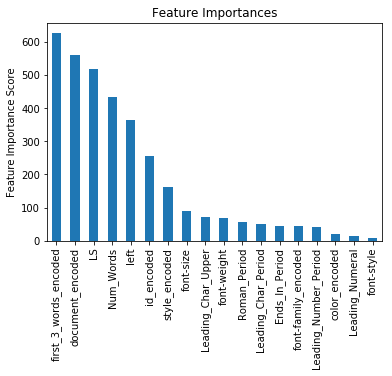

In [61]:
xgb2 = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=175,
        max_depth=10,
        min_child_weight=1,
        gamma=0.04,
        subsample=1,
        colsample_bytree=0.8,
        objective='binary:logistic',
        colsample_bylevel=1,
        reg_alpha=0,
        reg_lambda=0,
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb2, X_train_encoded, predictors)

In [62]:
y_pred = np.round(xgb2.predict(X_test_encoded))
y_pro = xgb2.predict_proba(X_test_encoded)[:, 1]

In [63]:
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.59
ROC AUC score: 0.72
True Negatives: 3096
False Negatives: 38
True Positives: 30
False Positives: 3
Precision: 0.91
Recall: 0.44


### Step 4: Tune subsample and colsample_bytree

In [64]:
param_test4 = {
    'subsample' : [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=175,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0.04,
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        objective='binary:logistic',
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test4, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch4.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.04, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=175, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=True, subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [65]:
results = pd.DataFrame(gsearch4.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch4.best_params_)
print("Its (best) score is", gsearch4.best_score_)

0     {'colsample_bytree': 0.6, 'subsample': 0.6}
1     {'colsample_bytree': 0.6, 'subsample': 0.7}
2     {'colsample_bytree': 0.6, 'subsample': 0.8}
3     {'colsample_bytree': 0.6, 'subsample': 0.9}
4     {'colsample_bytree': 0.7, 'subsample': 0.6}
5     {'colsample_bytree': 0.7, 'subsample': 0.7}
6     {'colsample_bytree': 0.7, 'subsample': 0.8}
7     {'colsample_bytree': 0.7, 'subsample': 0.9}
8     {'colsample_bytree': 0.8, 'subsample': 0.6}
9     {'colsample_bytree': 0.8, 'subsample': 0.7}
10    {'colsample_bytree': 0.8, 'subsample': 0.8}
11    {'colsample_bytree': 0.8, 'subsample': 0.9}
12    {'colsample_bytree': 0.9, 'subsample': 0.6}
13    {'colsample_bytree': 0.9, 'subsample': 0.7}
14    {'colsample_bytree': 0.9, 'subsample': 0.8}
15    {'colsample_bytree': 0.9, 'subsample': 0.9}
Name: params, dtype: object 0     0.668195
1     0.682838
2     0.680474
3     0.685866
4     0.683939
5     0.671392
6     0.697490
7     0.737622
8     0.699115
9     0.703448
10    0.696487
11    0

We have 0.7 for *colsample_bytree* and 0.9 for *subsample*, but let's do this again with a finer interval of 0.05

In [66]:
param_test5 = {
    'subsample' : [i/100.0 for i in range(65,80,5)],
    'colsample_bytree': [i/100.0 for i in range(85,100,5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=175,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0.04,
                                        subsample=0.9,
                                        colsample_bytree=0.9,
                                        objective='binary:logistic',
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test5, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch5.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.04, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=175, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.65, 0.7, 0.75], 'colsample_bytree': [0.85, 0.9, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [67]:
results = pd.DataFrame(gsearch5.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch5.best_params_)
print("Its (best) score is", gsearch5.best_score_)

0    {'colsample_bytree': 0.85, 'subsample': 0.65}
1     {'colsample_bytree': 0.85, 'subsample': 0.7}
2    {'colsample_bytree': 0.85, 'subsample': 0.75}
3     {'colsample_bytree': 0.9, 'subsample': 0.65}
4      {'colsample_bytree': 0.9, 'subsample': 0.7}
5     {'colsample_bytree': 0.9, 'subsample': 0.75}
6    {'colsample_bytree': 0.95, 'subsample': 0.65}
7     {'colsample_bytree': 0.95, 'subsample': 0.7}
8    {'colsample_bytree': 0.95, 'subsample': 0.75}
Name: params, dtype: object 0    0.693967
1    0.710640
2    0.721457
3    0.689347
4    0.712405
5    0.722288
6    0.683032
7    0.706747
8    0.706451
Name: mean_test_score, dtype: float64
The best parameters are {'colsample_bytree': 0.9, 'subsample': 0.75}
Its (best) score is 0.7222877221575985


$Tuned$ (so far)
- n_of_estimators = 175
- max_depth = 10
- min_child_weight = 1
- gamma = 0.04
- *colsample_by_tree* = 0.9
- *subsample* = 0.75

### Step 5: Tune regularization parameters

In [68]:
param_test6 = {
    'reg_alpha':[0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100],
    'reg_lambda':[0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=175,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0.04,
                                        colsample_bytree=0.9,
                                        subsample=0.75,
                                        objective='binary:logistic',
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test6, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch6.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.04, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=175, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.75),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'reg_lambda': [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [69]:
results = pd.DataFrame(gsearch6.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch6.best_params_)
print("Its (best) score is", gsearch6.best_score_)

0               {'reg_alpha': 0, 'reg_lambda': 0}
1           {'reg_alpha': 0, 'reg_lambda': 1e-05}
2          {'reg_alpha': 0, 'reg_lambda': 0.0001}
3           {'reg_alpha': 0, 'reg_lambda': 0.001}
4            {'reg_alpha': 0, 'reg_lambda': 0.01}
5             {'reg_alpha': 0, 'reg_lambda': 0.1}
6               {'reg_alpha': 0, 'reg_lambda': 1}
7              {'reg_alpha': 0, 'reg_lambda': 10}
8             {'reg_alpha': 0, 'reg_lambda': 100}
9           {'reg_alpha': 1e-05, 'reg_lambda': 0}
10      {'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
11     {'reg_alpha': 1e-05, 'reg_lambda': 0.0001}
12      {'reg_alpha': 1e-05, 'reg_lambda': 0.001}
13       {'reg_alpha': 1e-05, 'reg_lambda': 0.01}
14        {'reg_alpha': 1e-05, 'reg_lambda': 0.1}
15          {'reg_alpha': 1e-05, 'reg_lambda': 1}
16         {'reg_alpha': 1e-05, 'reg_lambda': 10}
17        {'reg_alpha': 1e-05, 'reg_lambda': 100}
18         {'reg_alpha': 0.0001, 'reg_lambda': 0}
19     {'reg_alpha': 0.0001, 'reg_lambda': 1e-05}


We have 1e-05 for *reg_alpha* and 0.0001 for *reg_lambda*. Let's tune this further with a fine interval.

In [70]:
param_test7 = {
    'reg_alpha':[i/1000000.0 for i in range(5, 15) ],
    'reg_lambda':[i/100000.0 for i in range(5, 15)]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=175,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0.04,
                                        colsample_bytree=0.9,
                                        subsample=0.75,
                                        objective='binary:logistic',
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test7, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch7.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.04, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=175, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.75),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [5e-06, 6e-06, 7e-06, 8e-06, 9e-06, 1e-05, 1.1e-05, 1.2e-05, 1.3e-05, 1.4e-05], 'reg_lambda': [5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 0.0001, 0.00011, 0.00012, 0.00013, 0.00014]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [71]:
results = pd.DataFrame(gsearch7.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch7.best_params_)
print("Its (best) score is", gsearch7.best_score_)

0         {'reg_alpha': 5e-06, 'reg_lambda': 5e-05}
1         {'reg_alpha': 5e-06, 'reg_lambda': 6e-05}
2         {'reg_alpha': 5e-06, 'reg_lambda': 7e-05}
3         {'reg_alpha': 5e-06, 'reg_lambda': 8e-05}
4         {'reg_alpha': 5e-06, 'reg_lambda': 9e-05}
5        {'reg_alpha': 5e-06, 'reg_lambda': 0.0001}
6       {'reg_alpha': 5e-06, 'reg_lambda': 0.00011}
7       {'reg_alpha': 5e-06, 'reg_lambda': 0.00012}
8       {'reg_alpha': 5e-06, 'reg_lambda': 0.00013}
9       {'reg_alpha': 5e-06, 'reg_lambda': 0.00014}
10        {'reg_alpha': 6e-06, 'reg_lambda': 5e-05}
11        {'reg_alpha': 6e-06, 'reg_lambda': 6e-05}
12        {'reg_alpha': 6e-06, 'reg_lambda': 7e-05}
13        {'reg_alpha': 6e-06, 'reg_lambda': 8e-05}
14        {'reg_alpha': 6e-06, 'reg_lambda': 9e-05}
15       {'reg_alpha': 6e-06, 'reg_lambda': 0.0001}
16      {'reg_alpha': 6e-06, 'reg_lambda': 0.00011}
17      {'reg_alpha': 6e-06, 'reg_lambda': 0.00012}
18      {'reg_alpha': 6e-06, 'reg_lambda': 0.00013}
19      {'re

$Tuned$ (so far)
- n_of_estimators = 175
- max_depth = 10
- min_child_weight = 1
- gamma = 0.04
- colsample_by_tree = 0.9
- subsample = 0.75
- *reg_alpha* = 1.2e-05
- *reg_lambda* = 0.00014

#### Try to run a model with all the parameters we've tuned so far for a learning rate of 0.1.

The best value of n_estimators is 74.
Will use and set this value as the parameter, accordingly.


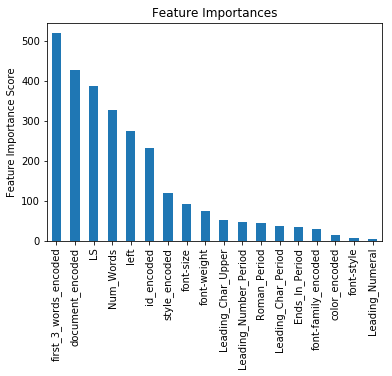

In [72]:
xgb3 = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=175,
        max_depth=10,
        min_child_weight=1,
        gamma=0.04,
        colsample_bytree=0.9,
        subsample=0.75,
        objective='binary:logistic',
        colsample_bylevel=1,
        reg_alpha=1.2e-05,
        reg_lambda=0.00014,
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb3, X_train_encoded, predictors)

In [73]:
y_pred = np.round(xgb3.predict(X_test_encoded))
y_pro = xgb3.predict_proba(X_test_encoded)[:, 1]
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.63
ROC AUC score: 0.74
True Negatives: 3098
False Negatives: 36
True Positives: 32
False Positives: 1
Precision: 0.97
Recall: 0.47


### Step 6: Reduce a learning rate and add more trees.

The best value of n_estimators is 56.
Will use and set this value as the parameter, accordingly.


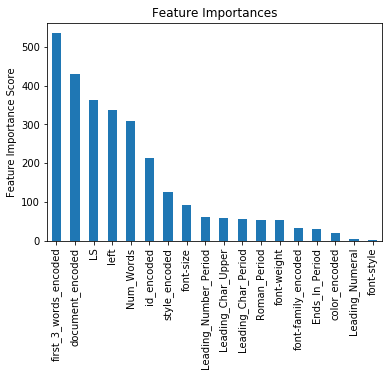

In [74]:
xgb4 = xgb.XGBClassifier(
        learning_rate=0.05,
        n_estimators=2000,
        max_depth=10,
        min_child_weight=1,
        gamma=0.04,
        colsample_bytree=0.9,
        subsample=0.75,
        objective='binary:logistic',
        colsample_bylevel=1,
        reg_alpha=1.2e-05,
        reg_lambda=0.00014,
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb4, X_train_encoded, predictors)

In [75]:
y_pred = np.round(xgb4.predict(X_test_encoded))
y_pro = xgb4.predict_proba(X_test_encoded)[:, 1]
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.55
ROC AUC score: 0.69
True Negatives: 3099
False Negatives: 42
True Positives: 26
False Positives: 0
Precision: 1.00
Recall: 0.38


$Tuned$ (for a learning rate of 0.05)
- n_of_estimators = 56
- max_depth = 10
- min_child_weight = 1
- gamma = 0.04
- colsample_by_tree = 0.9
- subsample = 0.75
- *reg_alpha* = 1.2e-05
- *reg_lambda* = 0.00014

The best value of n_estimators is 56.
Will use and set this value as the parameter, accordingly.


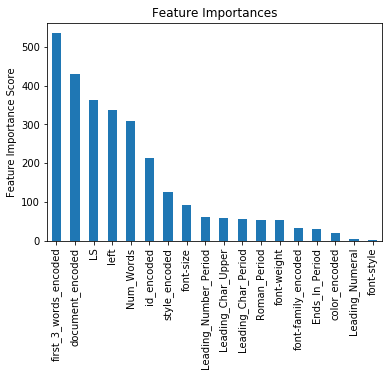

In [76]:
xgb5 = xgb.XGBClassifier(
        learning_rate=0.05,
        n_estimators=56,
        max_depth=10,
        min_child_weight=1,
        gamma=0.04,
        colsample_bytree=0.9,
        subsample=0.75,
        objective='binary:logistic',
        colsample_bylevel=1,
        reg_alpha=1.2e-05,
        reg_lambda=0.00014,
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb5, X_train_encoded, predictors)

In [77]:
y_pred = np.round(xgb5.predict(X_test_encoded))
y_pro = xgb5.predict_proba(X_test_encoded)[:, 1]
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.55
ROC AUC score: 0.69
True Negatives: 3099
False Negatives: 42
True Positives: 26
False Positives: 0
Precision: 1.00
Recall: 0.38


#### Feature Importances

In [78]:
#X = X_test
X = X_test_encoded
y = y_test
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb1)
shap_values = explainer.shap_values(X_train_encoded)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [79]:
shap_values = shap.TreeExplainer(xgb1).shap_values(X_train_encoded)

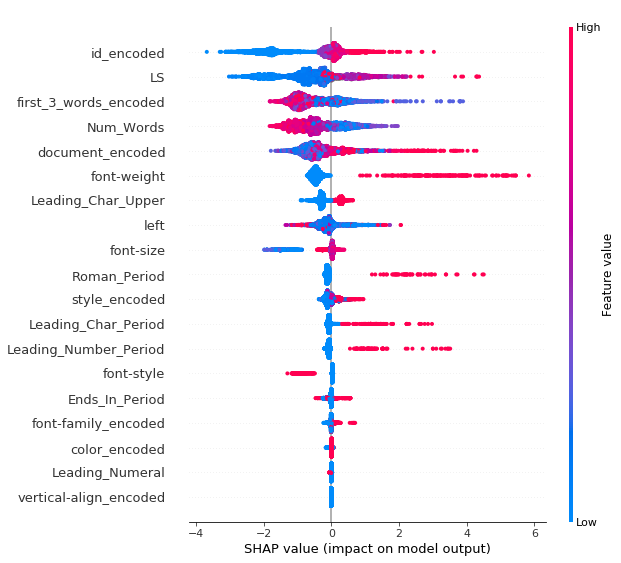

In [80]:
shap.summary_plot(shap_values, X_train_encoded)

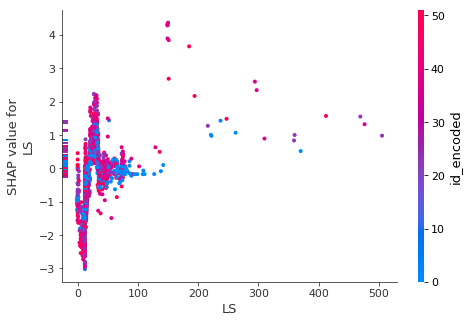

In [81]:
# we pass display_features so we get text display values for age
shap.dependence_plot("LS", shap_values, X_train_encoded)

In [82]:
def metrics(y_test, y_pred):
    print("Score on Train set")
    print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

In [83]:
y_test.shape, y_pred.shape

((3167,), (3167,))

In [84]:
metrics(y_test, y_pred)

Score on Train set
Accuracy score: 0.99
F1 score: 0.55
ROC AUC score: 0.69


In [85]:
def confusion_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print("Precision: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[0][1])))
    print("Recall: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[1][0])))

In [86]:
confusion_metrics(y_test, y_pred)

True Negatives: 3099
False Negatives: 42
True Positives: 26
False Positives: 0
Precision: 1.00
Recall: 0.38
